# Project goals

To determine the affect of weather on MLB attendance and whether the weather and related variables can reasonably predict attendance per game.

https://www.wsj.com/articles/major-league-baseball-sees-a-sharp-drop-in-attendance-1529063246?mod=hp_lead_pos8

# Steps:

1. Find reliable datasets
2. Clean and merge all relevant data
3. Exploratory data analysis for outliers, missing values, etc.
4. Feature selection
5. Model building and interpretation
6. Statistical Testing and Inference
7. Results and conclusion

In [1]:
## Import libraries

import pandas as pd # Data storage and manipulation
import numpy as np # Mathematical operations
import matplotlib.pyplot as plt # Plotting and visualization
import seaborn as sns # Plotting and visualization
import dc_stat_think as dcst #Statistical significance testing

pd.options.display.max_columns = None

sns.set()

pd.options.mode.chained_assignment = None

from sklearn.model_selection import train_test_split # Data splitting for modeling
from sklearn.metrics import mean_absolute_error as mae # Error metric for models

## Game data:

1. All data was taken from Retrosheet.org. Standard disclaimer from their website: The information used here was obtained free of charge from and is copyrighted by Retrosheet.  Interested parties may contact Retrosheet at "www.retrosheet.org".
2. Downloads were done for game logs from 1990-2017, which includes ~160+ total variables.
3. Each year's data was saved as a .txt file and read in collectively using the code below.

In [2]:
## Read in game datasets

df_all = pd.DataFrame()

for i in range (1990, 2018):
    df = pd.read_csv(r'C:\Users\jbean\Dropbox\Other\Python\baseballdatabank-2017.1\Project\Game Data\GL%s.txt' % i,header=None)
    
    df_all = pd.concat([df_all, df])

In [3]:
## Isolate relevant columns and assign names; "Relevant columns" include numerical data and other categorical variables
## that could feature in a final analysis or model.

df_all = df_all.iloc[:,np.r_[0,2:11, 12, 16:19, 21:27, 30, 32, 38, 49:55, 58, 60, 66, 160]]
cols = ['Date','Day_of_week','Visitor','V_league','V_game_num','Home','H_league','H_game_num','V_score','H_score','Time_of_day','Park','Attendance','Game_time','V_atbats','V_hits','V_doubles','V_triples','V_hr','V_rbi','V_bb','V_strikeouts','V_pitchersused','H_atbats','H_hits','H_doubles','H_triples','H_hr','H_rbi','H_bb','H_strikeouts','H_pitchersused','Data_quality']
df_all.columns = cols

df_all.head()

,Date,Day_of_week,Visitor,V_league,V_game_num,Home,H_league,H_game_num,V_score,H_score,Time_of_day,Park,Attendance,Game_time,V_atbats,V_hits,V_doubles,V_triples,V_hr,V_rbi,V_bb,V_strikeouts,V_pitchersused,H_atbats,H_hits,H_doubles,H_triples,H_hr,H_rbi,H_bb,H_strikeouts,H_pitchersused,Data_quality
0,19900409,Mon,DET,AL,1,BOS,AL,1,2,5,D,BOS07,35199.0,167.0,33,5,1,0,0,2,4,6,3,33,8,4,0,0,4,4,3,3,Y
1,19900409,Mon,SEA,AL,1,CAL,AL,1,7,4,N,ANA01,38406.0,176.0,40,15,2,0,1,7,1,2,3,31,5,0,0,1,3,5,6,5,Y
2,19900409,Mon,MIL,AL,1,CHA,AL,1,1,2,D,CHI10,40008.0,158.0,30,4,1,0,0,1,1,8,3,29,6,1,1,0,1,2,1,5,Y
3,19900409,Mon,BAL,AL,1,KCA,AL,1,7,6,D,KAN06,37671.0,211.0,45,14,1,0,2,6,2,8,5,44,10,1,0,2,6,4,3,4,Y
4,19900409,Mon,MIN,AL,1,OAK,AL,1,3,8,N,OAK01,48219.0,170.0,37,10,1,0,1,3,2,3,3,32,11,2,0,2,7,6,4,3,Y


## Weather data 

Notes:
1. All data was collected from w2.weather.gov > Climate > City, with monthly averages for every year between 1990 and 2017.
2. The two Chicago teams were given the same weather data
3. For other inter-city teams (Yankees/Mets, Angels/Dodgers, Oakland/SF) distinct temperatures were used to capture weather in different neighborhoods that were closer to the team's ballpark. For example, the Central Park weather data was used for the Yankees while Queens data was used for the Mets.
4. For TOR, data for Buffalo, NY was used for consistency of data source and proximity; likewise, the Plattsburgh, NY data was used for Montreal, which was a bit more of a stretch geographically, but MON has an indoor stadium, partially mitigating the assumption.
5. The "Stadium_type" columns is 1 for indoor ballparks and 0 for outdoor. Stadiums with a retractable roof (e.g. Seattle) were considered outdoor. Only fully indoor stadiums, such as Montreal's stadium, were classified as indoor. For teams that switched from an indoor to outdoor stadium over the course of the dataset, that was incorporated into the variable (for example, Minnesota switched from an indoor to an outdoor stadium starting in 2010.

In [4]:
## Read in the aggregated weather data

df_weather = pd.read_csv(r'C:\Users\jbean\Dropbox\Other\Python\baseballdatabank-2017.1\Project\city_weather_data.csv')
df_weather['Date'] = pd.to_datetime(df_weather['Date'])

df_weather.set_index('Date',inplace=True)
df_weather.index = df_weather.index.to_period('M').to_timestamp('M') # Match format of Date to monthly grouped game data
df_weather['month'] = df_weather.index.month
df_weather.head()

,Temperature,City,Stadium_Type,month
Date,,,,
1990-04-30,47.6,BOS,0,4
1990-05-31,54.9,BOS,0,5
1990-06-30,66.6,BOS,0,6
1990-07-31,73.1,BOS,0,7
1990-08-31,73.3,BOS,0,8


In [5]:
## Convert date to datetime and set as index

df_all['Date'] = pd.to_datetime(df_all['Date'],format='%Y%m%d')

df_all.set_index('Date',inplace=True)

In [6]:
## Set up a column that will sum games when grouped; will be used to calculate per/game metrics after groupby operations
## are performed in later analyses.

df_all['game'] = 1

In [7]:
## FLO = MIA, ANA = CAL; reflect name changes but they are the same team (http://www.retrosheet.org/CurrentNames.csv)

df_all.replace('FLO','MIA',inplace=True)
df_all.replace('CAL','ANA',inplace=True)

# Exploratory Data Analysis

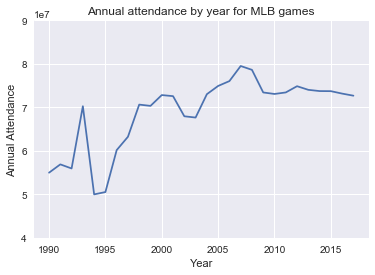

In [8]:
## Group the data by year and plot the annual attendance overall (axis in millions)

grouped_year = pd.DataFrame(df_all.groupby(df_all.index.year).sum())

grouped_year['Attendance'] = grouped_year['Attendance'].astype(int)

plt.plot(grouped_year['Attendance'])
plt.xlabel('Year')
plt.ylabel('Annual Attendance')
plt.title('Annual attendance by year for MLB games')
plt.ylim([40000000, 90000000])

plt.show()

Overall attendance is a good macro factor, but attendance per game is a more accurate metric in this case, so we will create that variable.

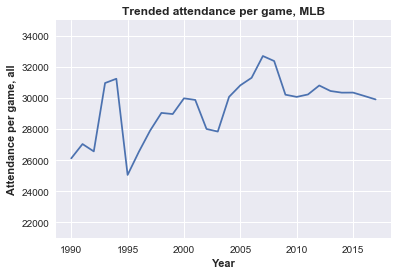

In [9]:
## Create attendance per game variable and see how that changes per year

grouped_year['attendance_per_game'] = grouped_year['Attendance'] / grouped_year['game']

plt.plot(grouped_year['attendance_per_game'])

plt.xlabel('Year',fontweight='bold')
plt.ylabel('Attendance per game, all',fontweight='bold')
plt.title('Trended attendance per game, MLB',fontweight='bold')
plt.ylim([21000,35000])

plt.show()

# What's going on in the mid 90's?

Total attendance shows a pretty steep dropoff in 1994 and 1995, and on a per-game basis, the 1995 data shows a drop of over 6,000 fans per game, on average, for the season. What's the deal?

This is where EDA helps us contextualize the data that we have. A bit of digging shows that MLB had a players strike that started near the end of the 1994 season and continued through April 1995. This not only explains the lower overall attendance, but we can also make some inferences about 1995. For example, the drop in attendance could very well be from a drop in fan trust as a result of the strike, and the way they show distrust is via not going to games.

We also see on a per-game basis, MLB didn't recover to their pre-strike peak until around 2006, after which they gained through 2008, followed by another drop. This time, the more likely cause for the drastic drop in attendance is a more macroeconomic factor, the Great Recession.

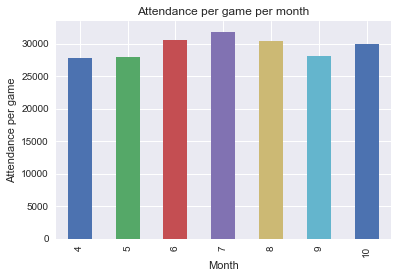

In [10]:
## Isolate average attendance per month to see the impact of missing August and September for a season

grouped_month = df_all.groupby(by=df_all.index.month).sum()
grouped_month = grouped_month[grouped_month.index != 3] # Exclude March because it's a smaller sample size
attendance_per_month = grouped_month['Attendance'] / grouped_month['game']

attendance_per_month.plot(kind='bar')
plt.xlabel('Month')
plt.ylabel('Attendance per game')
plt.title('Attendance per game per month')

plt.show()

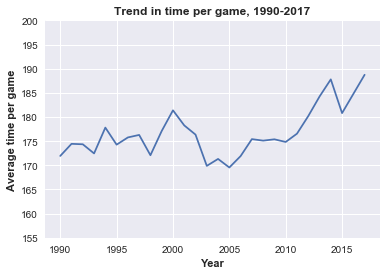

In [11]:
## Plot the change in time per game to see if game time has increased between 1990 and 2017

grouped_year['time_per_game'] = grouped_year['Game_time'] / grouped_year['game']

plt.plot(grouped_year['time_per_game'])
plt.xlabel('Year', fontweight='bold')
plt.ylabel('Average time per game',fontweight='bold')
plt.title('Trend in time per game, 1990-2017',fontweight='bold')
plt.ylim([155, 200])

plt.show()

In tandem with the change in attendance, the average length of an MLB game is a worthwhile statistic to understand other factors at play. Historically seen as a slower paced game compared to basketball or football, this graphic isn't a good trending sign for MLB. Since 2005, the average time per game has increased by more than 10%, with a largely steady upward trend. The importance of this trend is that part of the drop in attendance may be a result of longer game times. This is something we'll test later.

In order to combat this trend, MLB has implemented a number of smaller rules that should collectively work to speed up games. These include limiting the length of time between innings, number of mound visits for each team, and keeping batters in the box, among others.

In [12]:
## Create aggregated HR and run columns to provide proxy for offensive output; look for other potentially
## correlated variables to attendance per game.

grouped_year['total_hr_game'] = (grouped_year['V_hr'] + grouped_year['H_hr']) / grouped_year['game']
grouped_year['total_run_game'] = (grouped_year['V_score'] + grouped_year['H_score']) / grouped_year['game']

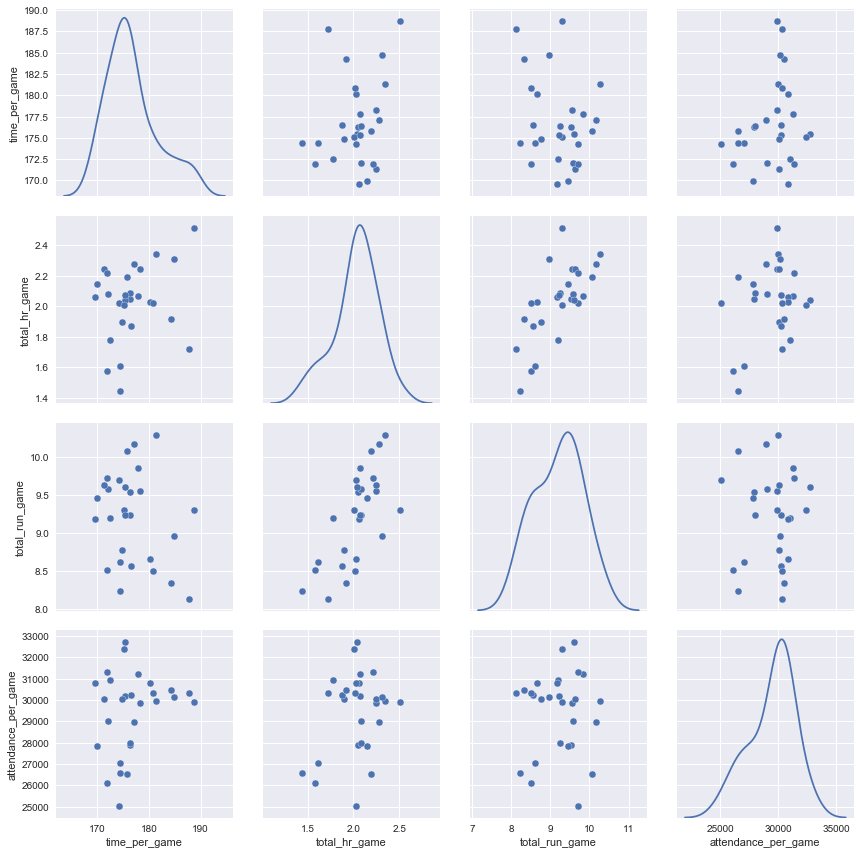

In [13]:
## Look for correlations between attendance and some common variables

corr_columns = ['time_per_game','total_hr_game','total_run_game','attendance_per_game']

sns.pairplot(grouped_year[corr_columns], diag_kind = 'kde',size=3)

plt.show()

In [14]:
## Create a dataframe that groups by month and year for more data points

df_m_y = pd.DataFrame(df_all.groupby(by=[df_all.index.year, df_all.index.month]).sum())

In [15]:
## Add the same variables to the monthly data for more overall data points

df_m_y['total_hr_game'] = (df_m_y['V_hr'] + df_m_y['H_hr']) / df_m_y['game']
df_m_y['total_run_game'] = (df_m_y['V_score'] + df_m_y['H_score']) / df_m_y['game']
df_m_y['time_per_game'] = df_m_y['Game_time'] / df_m_y['game']
df_m_y['attendance_per_game'] = df_m_y['Attendance'] / df_m_y['game']

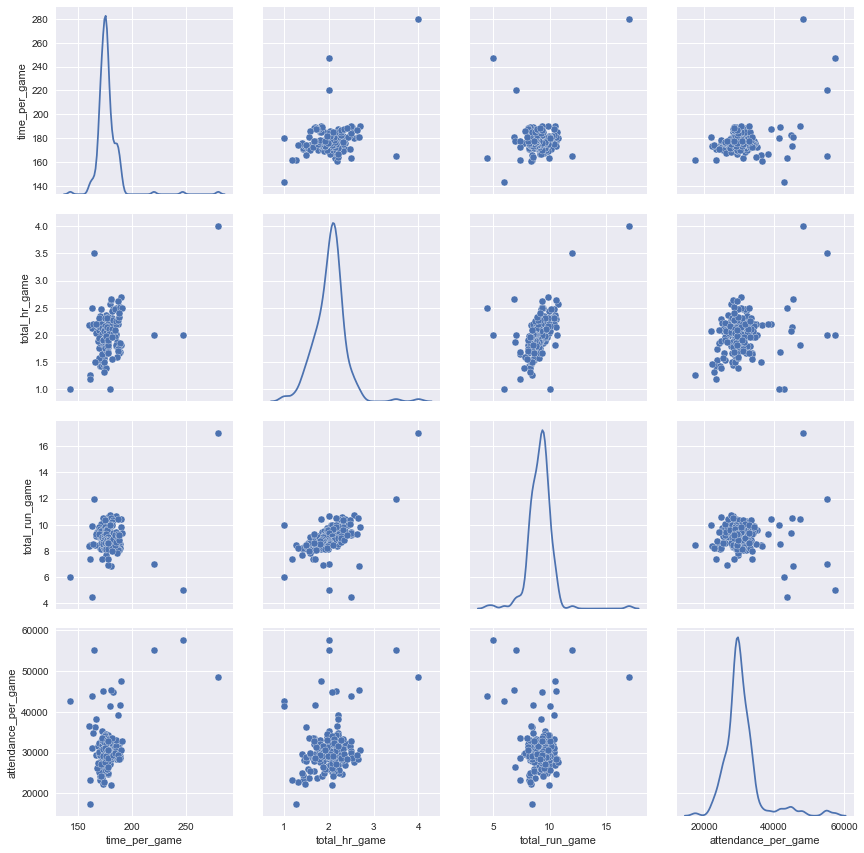

In [16]:
## Look for correlations between attendance and some common variables

sns.pairplot(df_m_y[corr_columns], diag_kind = 'kde',size=3)

plt.show()

# Findings

In looking for factors that could correlate with attendance per game outside of Temperature, I started with a few initial hypotheses. More offensive output (runs and/or homeruns) would be more exciting for fans, thereby generating higher attendance. Likewise, intuititively we would think that shorter time for games may increase attendance, but this also doesn't look to be the case from the plot.

In [17]:
## Add HR and Run variables to the full dataframe

df_all['total_hr_game'] = (df_all['V_hr'] + df_all['H_hr'])
df_all['total_run_game'] = (df_all['V_score'] + df_all['H_score'])

In [18]:
## Resample the dataframe by Month and Year; remove additional months that had all 0's that were not 
## included in DF (December, January, etc.)

df_monthly = df_all.resample('M').sum()
df_monthly.drop(df_monthly[df_monthly.game < 1].index, inplace=True) # Remove offseason months

In [19]:
## Add variables to new monthly dataframe

df_monthly['hr_game'] = df_monthly['total_hr_game'] / df_monthly['game']

df_monthly['total_run_game'] = df_monthly['total_run_game'] / df_monthly['game']

df_monthly['attendance_per_game'] = df_monthly['Attendance'] / df_monthly['game']

In [20]:
## Create a new DF that is regular season only to mitigate potential bias of increased attendance at postseason games

df_monthly_rs = df_monthly[(df_monthly.index.month >= 4) & (df_monthly.index.month <= 9)]

In [21]:
## Group the weather data by month, filter out November, use monthly resampled dataset filtered for April onward
## and add variables; end goal is to plot temperature against attendance per game.

weather_month = df_weather.groupby(df_weather.index).mean()
weather_month = weather_month[weather_month['month'] != 11.0]

attendance_month = df_monthly[df_monthly > '04/01'] # Date filtering
attendance_month['attendance_per_game'] = attendance_month['Attendance'] / attendance_month['game']

Correlation between Temperature and attendance per game: 0.15


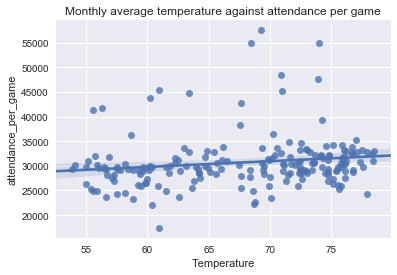

In [22]:
## Scatter plot for attendance against average fans per game; aw = attendance + weather

aw_month = weather_month[['Temperature']]
aw_month['attendance_per_game'] = attendance_month['attendance_per_game'].values

sns.regplot(x='Temperature',y='attendance_per_game',data=aw_month)
plt.title('Monthly average temperature against attendance per game')

print('Correlation between Temperature and attendance per game: %.2f' % aw_month.corr().iloc[0,1])

At first glance, there's surprisingly little relation between Temperature and attendance per game. The correlation coefficient is slightly positive, but if we were to remove some of the values in the upper third of the plot, the relationship may drop to essentially 0.

This means that there are likely other factors that are more influential to attendace per game than temperature. These could include the team's record (this season or last), the team in town (for example, playing against the Yankees might draw a bigger crowd than Toronto), or playoff positioning (competing for a playoff spot in September vs. mid-July game in the Texas heat with the team sub-.500).

In [23]:
## Join team and weather data to group each team by month and see how the data distributes

df_weather.sort_index(inplace=True)

df_all['month'] = df_all.index.month

df_all_month = df_all.groupby(by=['month','Home']).sum()
df_all_month = df_all_month.loc[4:11]

df_weather_mt = df_weather.groupby(by=[df_weather.index.month,'City']).mean()
df_weather_mt = df_weather_mt.loc[4:10]

df_total_yr = pd.concat([df_all_month, df_weather_mt[['Temperature','Stadium_Type']]],axis=1)

df_total_yr.head(10)

V_game_num  H_game_num  V_score  H_score  Attendance  Game_time  \
month Home                                                                    
4     ANA         4017        4036     1521     1500  11002699.0    59062.0   
      ARI         3509        3577     1380     1407   7791983.0    47498.0   
      ATL         3621        3677     1169     1322   9160879.0    51438.0   
      BAL         3992        3931     1444     1514   9974960.0    57824.0   
      BOS         4213        4198     1415     1676  10325894.0    59548.0   
      CHA         4232        4161     1373     1497   6667771.0    55232.0   
      CHN         3821        3721     1337     1382   9424494.0    53000.0   
      CIN         3568        3596     1561     1456   7722879.0    55876.0   
      CLE         3906        3820     1453     1365   6801755.0    51679.0   
      COL         3796        3773     1782     1788  10273776.0    52452.0   

            V_atbats  V_hits  V_doubles  V_triples  V_hr  V_rbi  V_bb  \
month Home                                                              
4     ANA      11682    3002        606         36   355   1442  1179   
      ARI       9496    2528        577         59   327   1312   863   
      ATL      10307    2477        480         48   230   1098  1018   
      BAL      11212    2782        501         34   363   1372  1183   
      BOS      11068    2769        649         44   281   1340  1125   
      CHA      10836    2648        518         49   286   1301  1131   
      CHN      10497    2556        510         58   304   1263  1100   
      CIN      11025    2780        595         62   377   1480  1142   
      CLE      10184    2680        554         38   302   1371   993   
      COL      10409    3059        642         76   358   1703  1099   

            V_strikeouts  V_pitchersused  H_atbats  H_hits  H_doubles  \
month Home                                                              
4     ANA           2271            1154     11157    2927        541   
      ARI           1964            1064      9034    2440        525   
      ATL           2196            1110      9967    2575        477   
      BAL           2121            1158     10740    2803        539   
      BOS           2403            1181     10773    3044        719   
      CHA           2165            1125     10355    2680        500   
      CHN           2390            1147     10178    2641        512   
      CIN           2407            1235     10471    2671        516   
      CLE           1976            1029      9570    2496        509   
      COL           1861            1123      9988    3018        610   

            H_triples  H_hr  H_rbi  H_bb  H_strikeouts  H_pitchersused  game  \
month Home                                                                     
4     ANA          53   312   1415   966          1962            1231   331   
      ARI          75   339   1350   935          1784            1056   269   
      ATL          52   297   1261  1046          1993            1135   302   
      BAL          37   339   1424  1133          1926            1191   324   
      BOS          59   328   1580  1254          1995            1202   319   
      CHA          66   363   1424  1162          1862            1138   314   
      CHN          54   288   1311  1066          2068            1194   305   
      CIN          53   356   1365  1179          2191            1253   320   
      CLE          42   308   1307  1098          1866            1113   287   
      COL         115   359   1706  1022          1821            1211   286   

            total_hr_game  total_run_game  Temperature  Stadium_Type  
month Home                                                            
4     ANA             667            3021    64.103571           0.0  
      ARI             666            2787    72.867857           1.0  
      ATL             527            2491    62.978571          

In [24]:
## Define function that allows us to calculate a per/game statistic to cancel out some of the data noise

def stat_per_game(df, col1, col2='game'):
    
    """
    
    Returns the normalized value of the test statistic on a per/game basis.
    
    """
    
    stat_per_game = df.loc[:,col1] / df.loc[:,col2]
    
    return stat_per_game

Correlation between attendance per game and Temperature: 0.14


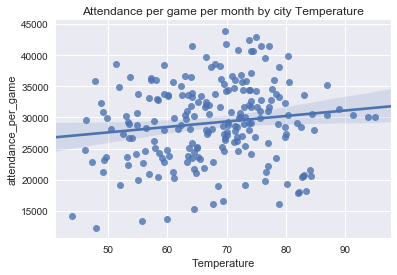

In [25]:
## Create another scatter plot to measure Temperature against attendance using grouped dataframe that takes into account
## changes in city/team rather than aggregated monthly values, then look at the linear relationship and correlation.

df_total_yr['attendance_per_game'] = stat_per_game(df_total_yr, 'Attendance')

sns.regplot(x='Temperature', y='attendance_per_game', data=df_total_yr)
plt.title('Attendance per game per month by city Temperature')

corr = df_total_yr[['Temperature','attendance_per_game']].corr()

print('Correlation between attendance per game and Temperature: %.2f' %corr.iloc[0,1])

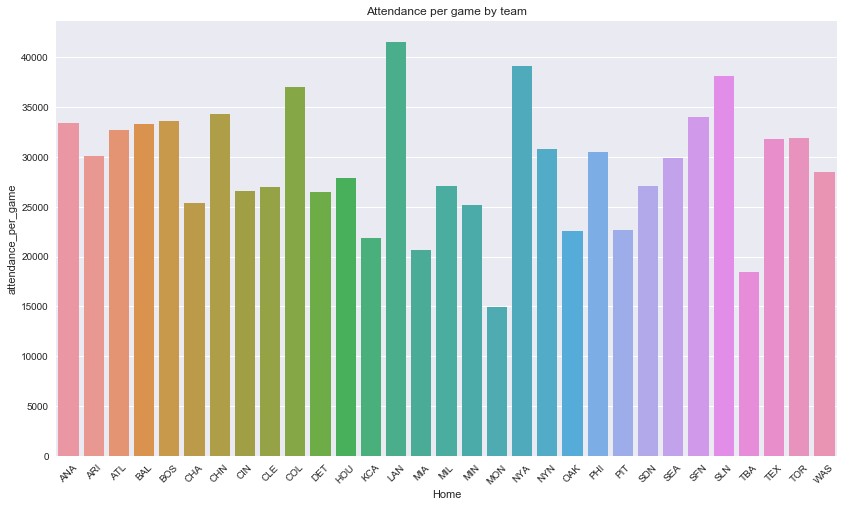

In [26]:
## Create a dataframe grouped by team and see how average attendance per game changes per team

df_teams = pd.DataFrame(df_all[['Home','Attendance','game']].groupby(by='Home').sum())
df_teams['attendance_per_game'] = stat_per_game(df_teams, 'Attendance','game')

fig = plt.figure(figsize=(14, 8))

ax= sns.barplot(x=df_teams.index, y='attendance_per_game', data=df_teams)

plt.xticks(rotation=45)
plt.title('Attendance per game by team')

plt.show()

In [27]:
## Create a new dataframe that has all of the team and weather information.
## The new dataframe groups and sums the statistics for each month of each year, then joins the weather data for that
## period to the dataframe. This is an uncoupled version of the dataframe made above that now allows us to manipulate,
## plot, and model the data with included temperature data.

new_df_all = pd.DataFrame()

for team in list(set(df_all['Home'])):
    
    teams = df_all[df_all['Home'] == team] # Filter for each specific team
    teams = teams.resample('M').sum() # Resample to monthly data with inputs summed
    teams = teams[teams['game'] > 0] # Eliminate offseason months
    teams = teams[teams.index.month.isin([4,5,6,7,8,9])] # Include only regular season

    weather = df_weather[df_weather['City'] == team] # Filter weather data for team
    weather = weather.resample('M').mean() # Resample by month
    weather = weather[(weather['Temperature'] > 0) & (weather['month'] < 10)] # Eliminate offseason months
    
    weather.drop(weather[weather.index.isin(teams.index) == False].index,inplace=True) #Drops rows where the date is 
    #not in the team index (such as when the strike occurred)
    
    new_teams = pd.concat([teams, weather],axis=1) # Merge datasets
    new_teams['team'] = team # Add team variable for identification
    new_teams = pd.DataFrame(new_teams)

    new_df_all = new_df_all.append(new_teams)
    
new_df_all.head()

,V_game_num,H_game_num,V_score,H_score,Attendance,Game_time,V_atbats,V_hits,V_doubles,V_triples,V_hr,V_rbi,V_bb,V_strikeouts,V_pitchersused,H_atbats,H_hits,H_doubles,H_triples,H_hr,H_rbi,H_bb,H_strikeouts,H_pitchersused,game,total_hr_game,total_run_game,month,Temperature,Stadium_Type,month,team
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1990-04-30,48,54,33,23,108296.0,949.0,208,62,17,1,3,30,23,30,15,194,51,9,0,3,23,21,28,21,6,6,56,24,53.3,0.0,4.0,PHI
1990-05-31,455,451,81,75,338900.0,2451.0,487,136,28,2,18,81,56,61,43,469,138,23,5,10,73,54,76,47,14,28,156,70,61.3,0.0,5.0,PHI
1990-06-30,899,876,47,57,392520.0,2499.0,494,112,23,3,12,44,59,79,41,495,124,17,1,12,53,54,68,38,15,24,104,90,72.2,0.0,6.0,PHI
1990-07-31,993,990,56,48,390412.0,2001.0,413,102,25,4,13,55,47,71,31,382,86,13,2,9,46,45,82,40,12,22,104,84,78.0,0.0,7.0,PHI
1990-08-31,1593,1573,77,52,386692.0,2515.0,513,143,36,5,10,70,58,83,43,477,123,25,1,7,49,53,67,53,14,17,129,112,75.8,0.0,8.0,PHI


In [28]:
## Add attendance per game variable to new Dataframe

new_df_all['attendance_per_game'] = stat_per_game(new_df_all, 'Attendance','game')

Correlation coefficient between attendance per game and Temperature: 0.09


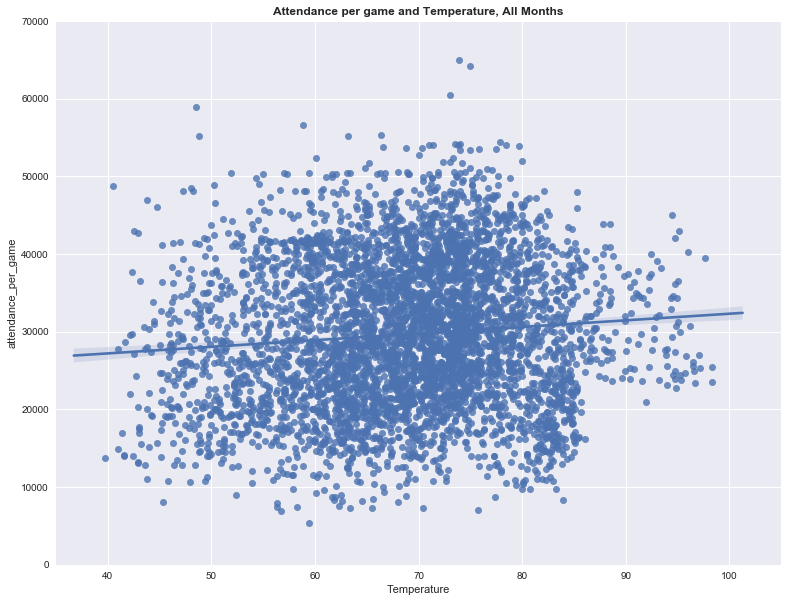

In [29]:
## Scatter plot to do a further dive into the temperature and attendance per game relationship, this time incorporating
## a data point for each month of each year for every team.

fig, ax = plt.subplots(figsize=(13, 10))

ax = sns.regplot(x='Temperature',y='attendance_per_game', data=new_df_all)
plt.xlim([35, 105])
plt.ylim([0, 70000])
plt.title('Attendance per game and Temperature, All Months', fontweight='bold')

print('Correlation coefficient between attendance per game and Temperature: %.2f' % new_df_all[['Temperature', 'attendance_per_game']].corr().iloc[0,1])

In [30]:
## Create a dictionary with the median temperatures for each month over the timespan

city_median_month_temps = {}

for team in list(set(new_df_all['team'])):
    
    city = new_df_all[new_df_all['team'] == team]
    city_grpd = city.groupby(by=city.index.month).median()

    city_median_month_temps[team] = list(zip(city_grpd.index, round(city_grpd['Temperature'],1)))
        
city_median_month_temps

{'ANA': [(4, 64.1), (5, 66.4), (6, 70.0), (7, 73.6), (8, 75.0), (9, 73.7)],
 'ARI': [(4, 73.6), (5, 82.9), (6, 92.4), (7, 95.4), (8, 94.3), (9, 89.7)],
 'ATL': [(4, 62.4), (5, 71.0), (6, 77.7), (7, 80.4), (8, 79.5), (9, 73.8)],
 'BAL': [(4, 54.9), (5, 63.7), (6, 73.4), (7, 78.2), (8, 75.9), (9, 69.0)],
 'BOS': [(4, 49.0), (5, 58.5), (6, 68.2), (7, 74.3), (8, 72.8), (9, 65.3)],
 'CHA': [(4, 49.4), (5, 59.7), (6, 69.6), (7, 74.2), (8, 73.2), (9, 64.7)],
 'CHN': [(4, 49.4), (5, 59.7), (6, 69.6), (7, 74.2), (8, 73.2), (9, 64.7)],
 'CIN': [(4, 54.9), (5, 63.4), (6, 72.7), (7, 75.0), (8, 74.7), (9, 67.7)],
 'CLE': [(4, 49.4), (5, 60.2), (6, 69.4), (7, 73.4), (8, 72.2), (9, 65.0)],
 'COL': [(4, 48.0), (5, 57.5), (6, 68.2), (7, 74.5), (8, 71.7), (9, 64.2)],
 'DET': [(4, 49.8), (5, 60.7), (6, 70.6), (7, 73.8), (8, 72.9), (9, 64.4)],
 'HOU': [(4, 69.4), (5, 77.0), (6, 82.2), (7, 84.2), (8, 84.7), (9, 79.8)],
 'KCA': [(4, 54.8), (5, 63.9), (6, 73.9), (7, 77.8), (8, 77.0), (9, 68.8)],
 'LAN': [(4,

# Variable creation

Goal: Create a dummy variable to determine when a row observation is below the median temperature for that city, which will allow us to determine whether lower temperature games show meaningfully lower attendance.

1. Match the team name to the name in the dictionary
2. Find the month of the observation
3. Match the observation month to the dictionary month
4. Find the Temperature column for that row
5. Compare the Temperature in the row for the median temperature for that row
6. Create a (1) variable for anywhere that the temperature is below the Median temperature or a (0) otherwise


In [31]:
copied_df = new_df_all.copy()
copied_df.reset_index(inplace=True)

copied_df['month'] = new_df_all.index.month
copied_df['month'] = copied_df['month'].replace({4:0, 5:1, 6:2, 7:3, 8:4, 9:5}) # Aligns month values with dictionary index values

copied_df = copied_df[['attendance_per_game', 'team','month','Temperature']]

all_nums = []

for val in range(len(copied_df)):
         
    team = copied_df.iloc[val,-4]
    month = copied_df.iloc[val, -3]
    temp = copied_df.iloc[val, -1]
    median_temp = city_median_month_temps.get(team)[month][1]
    
    num = [1 if temp < median_temp else 0]
    all_nums.append(num)

new_df_all['below_median'] = all_nums
new_df_all['below_median'] = [x[0] for x in new_df_all['below_median']] # Extracts value from list of lists

print(new_df_all[['team','Temperature','below_median']].head(10))

           team  Temperature  below_median
Date                                      
1990-04-30  PHI         53.3             1
1990-05-31  PHI         61.3             1
1990-06-30  PHI         72.2             1
1990-07-31  PHI         78.0             1
1990-08-31  PHI         75.8             1
1990-09-30  PHI         68.0             1
1991-04-30  PHI         55.5             0
1991-05-31  PHI         70.8             0
1991-06-30  PHI         75.7             0
1991-07-31  PHI         79.0             1


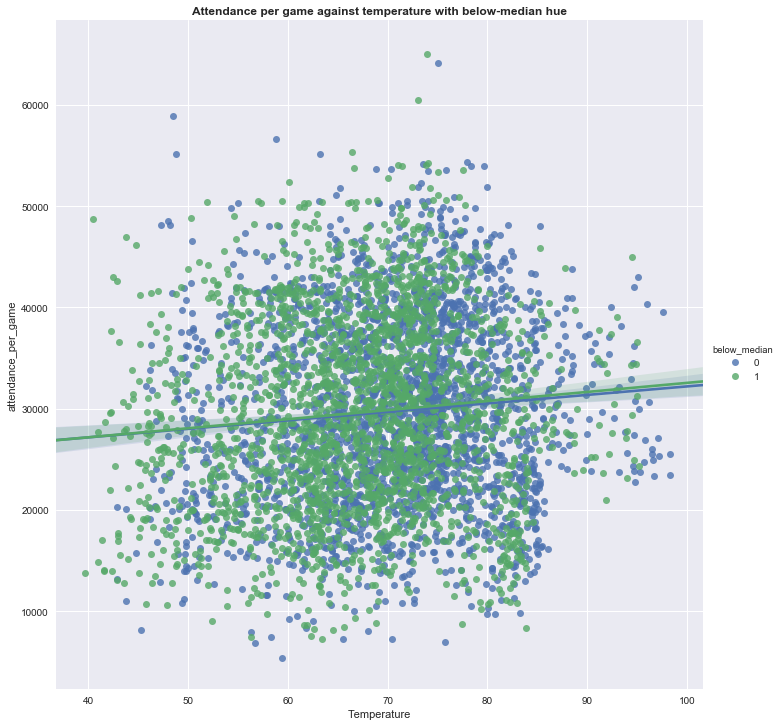

In [32]:
## Plot attendance per game against temperature with a hue set to whether the temperature was above or 
## below the median for each team; 1 = Below median, 0 = Above median

sns.lmplot(x="Temperature", y="attendance_per_game", data=new_df_all, fit_reg=True, hue='below_median', legend=True, size=10)
plt.title('Attendance per game against temperature with below-median hue',fontweight='bold')

plt.show()

# Observations

It doesn't appear that there is a meaningful difference in attendance for games that are above or below the median temperature for a given team or city overall. The next step will be to isolate the months that will be most affected by temperature swings (April, May) since a temperature below the median in summer months is usually still pleasant to watch a game.

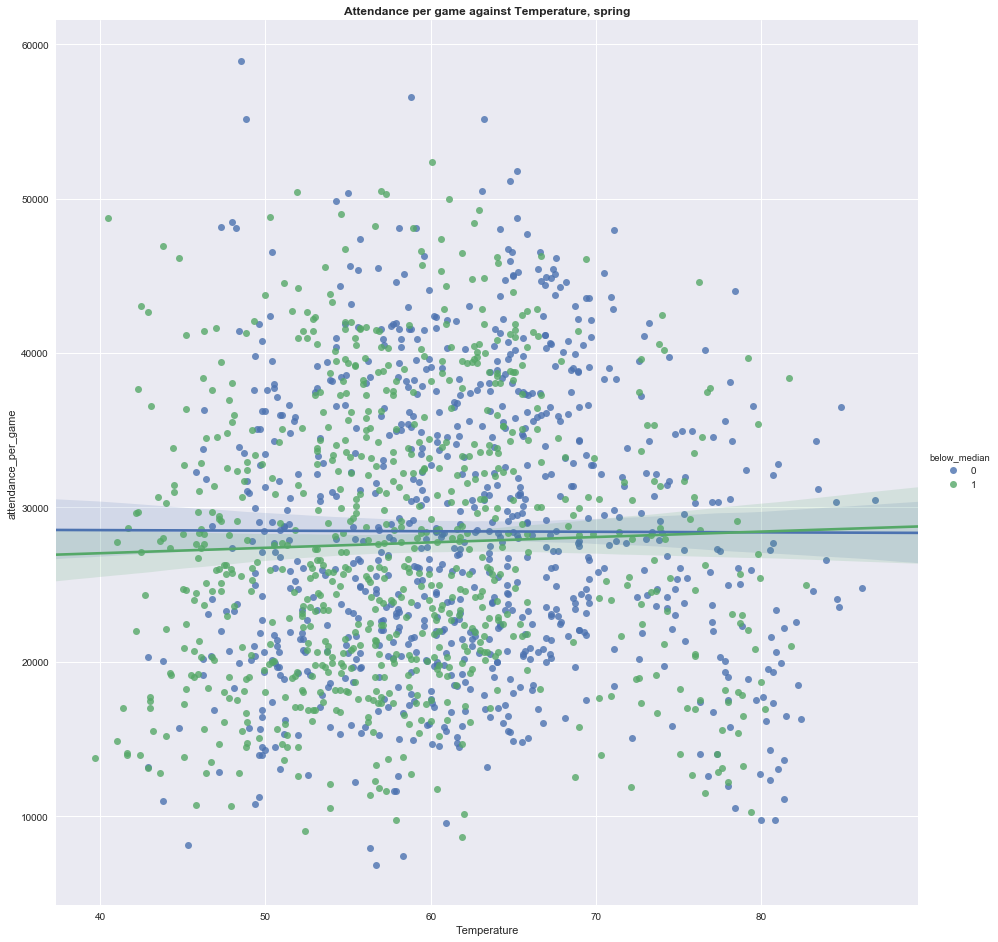

In [33]:
new_df_spring = new_df_all[new_df_all.index.month.isin([4,5])] # Date index is in April or May

sns.lmplot(x="Temperature", y="attendance_per_game", data=new_df_spring, fit_reg=True, hue='below_median', legend=True, size=13)
plt.title('Attendance per game against Temperature, spring', fontweight='bold')

plt.show()

# Observations

Once again, for spring only, we don't see a meaningful difference between temperature, attendance, and whether the temperature was below the median temperature. One last try at looking for a visual effect will be looking one level deeper - teams in "cold weather" cities (which I'm defining as a median temperature below 55 degrees in April) and whether there's any relationship in these cities.

In [34]:
## Create a list of the cold weather teams to filter spring dataframe

cold_weather_teams = []

for team, month in city_median_month_temps.items():
    if city_median_month_temps[team][0][1] <= 55.0: # Index first item in each team median (April) and the second element (temp)
        cold_weather_teams.append(team)

cold_weather_teams

['PHI',
 'NYA',
 'NYN',
 'SEA',
 'BOS',
 'DET',
 'COL',
 'CHA',
 'MIN',
 'PIT',
 'MIL',
 'CIN',
 'CHN',
 'BAL',
 'KCA',
 'CLE',
 'MON',
 'TOR']

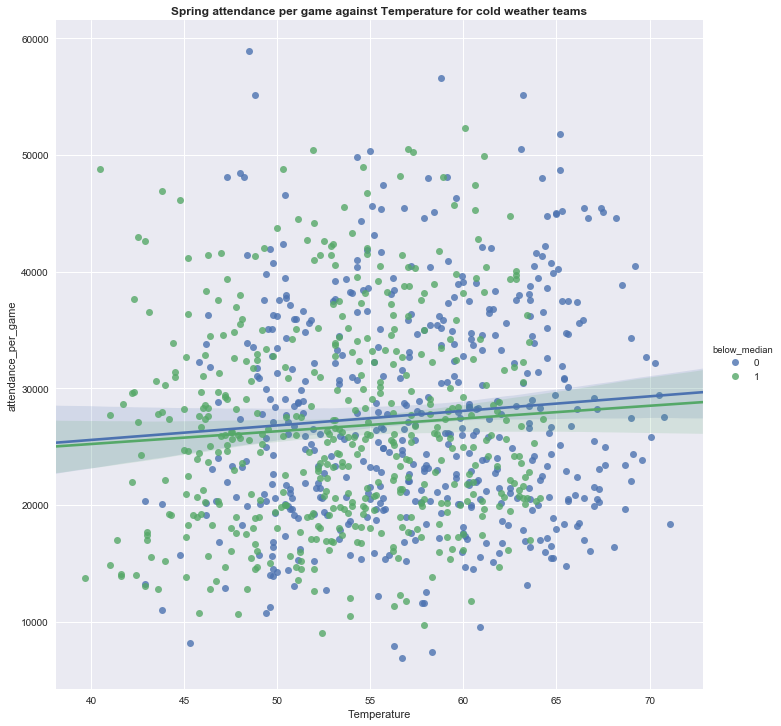

In [35]:
## Create a new dataframe with cold weather teams in spring months; plot relationship

cold_spring_teams = new_df_spring[new_df_spring['team'].isin(cold_weather_teams)]

sns.lmplot(x="Temperature", y="attendance_per_game", data=cold_spring_teams, fit_reg=True, hue='below_median', legend=True, size=10)
plt.title('Spring attendance per game against Temperature for cold weather teams', fontweight='bold')

plt.show()

In [36]:
## Find the slope of the Temperature and Attendance per game relationship

cst = cold_spring_teams.dropna(how='any')

slope_1, intercept_1 = np.polyfit(cst['Temperature'], cst['attendance_per_game'], 1)

print('The slope of a linear regression is: %.1f' % slope_1)


The slope of a linear regression is: 132.6


# Observations

Still no luck on finding a meaningful relationship between a temperature being above or below the median temperature, even in cold weather cities. While the relationship has a more positive slope than previous attempts, it still represents a change of just ~130 fans for each additional degree change in temperature. Put differently, a 10 degree change in weather will change the attendance per game estimate by ~1,300 fans.

We'll move on to other techniques to determine the importance of temperature - and being above or below the median temperature - on attendance.

# Model Building

There will be two more steps to this initial project, model building and statistical significance. First will be to try and see if we can make reasonably accurate predictions for attendance per game using weather metrics, and if yes, determine the relative importance of each of those factors, and see where temperature or related factors rank in this.

# Step 1: Baseline

We'll start by establishing a baseline prediction, measure the "accuracy" of this prediction, then compare our model results to those prediction accuracy measures and see if we were able to meaningfully reduce the variance.

In this case, I'm going to set the baseline prediction to the median value for each city for each month, and for model scoring I'm going to use Mean Absolute Error (MAE) which calculates the absolute difference between the observed value and predicted value, then sums that for the total set of observations and divides by the number of observations.

In [37]:
## Create a dictionary with the mean attendance per game values for each city for each month

city_attendance_mean = {}

for team in list(set(new_df_all['team'])):
    
    team_df = new_df_all[new_df_all['team'] == team]
    
    grpd_df = team_df.groupby(by=team_df.index.month).mean()
    grpd_df = grpd_df.drop_duplicates(keep='first')
    
    city_attendance_mean[team] = list(zip(grpd_df.index, round(grpd_df['attendance_per_game'],0)))

In [38]:
## Assign the mean monthly value for each team to a new column

mean_attendance = []

for val in range(len(copied_df)):
         
    team = copied_df.iloc[val,-4]
    month = copied_df.iloc[val, -3]
    attendance = copied_df.iloc[val, -5]
    mn_attendance = city_attendance_mean.get(team)[month][1]
    
    mean_attendance.append(mn_attendance)

new_df_all['mean_attendance'] = mean_attendance

In [39]:
print(new_df_all[new_df_all['team'] == 'NYA'][['team','attendance_per_game','mean_attendance']].head())

           team  attendance_per_game  mean_attendance
Date                                                 
1990-04-30  NYA         23700.000000          36641.0
1990-05-31  NYA         21788.200000          36922.0
1990-06-30  NYA         29166.083333          40498.0
1990-07-31  NYA         25395.384615          41485.0
1990-08-31  NYA         25593.000000          42051.0


In [40]:
## Verify that the mean attendance was correctly attributed to the city and month

city_attendance_mean['NYA']

[(4, 36641.0),
 (5, 36922.0),
 (6, 40498.0),
 (7, 41485.0),
 (8, 42051.0),
 (9, 38616.0)]

In [41]:
## Establish baseline MAE; first step is splitting train and test df's

X = new_df_all['mean_attendance']
y = new_df_all['attendance_per_game']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)

In [42]:
## Calculate the baseline mae

mae_baseline = mae(y_test, X_test)

print('Mean absolute error baseline: %.2f' %mae_baseline)

Mean absolute error baseline: 5550.63


# Linear Regression

Find the most relevant features, including dummy variables for team name, to predict attendance.

In [43]:
## Create dummy variables for team and add it to the new dataframe

team_dummies = pd.get_dummies(new_df_all['team'])
new_df_all = pd.concat([new_df_all, team_dummies], axis=1)

In [44]:
## Select numerical features, drop leading predictors, add month dummy variales, and aggregate into a new DF

fs_copy = new_df_all.copy()
fs_copy.dropna(how='any',axis=0, inplace=True)

X_1 = fs_copy.select_dtypes(include=['float','int64', 'uint8'])
X_1 = X_1.drop(['mean_attendance','attendance_per_game', 'Attendance'], axis=1)

month_dummies = pd.get_dummies(X_1.index.month)
month_dummies.columns = ['April','May','June','July','August','September']

X_1 = X_1.reset_index()
X_1 = pd.concat([X_1, month_dummies], axis=1)

In [45]:
## Predictor variable

y_1 = fs_copy['attendance_per_game']

In [46]:
## Extract relevant features

X_1t = X_1[['Temperature','below_median', 'April', 'May','June','July','August','September','ANA', 'ARI', 'ATL', 'BAL', 
            'BOS', 'CHA', 'CHN', 'CIN', 'CLE', 'COL', 'DET', 'HOU', 'KCA', 'LAN',
            'MIA', 'MIL', 'MIN', 'MON', 'NYA', 'NYN', 'OAK', 'PHI', 'PIT', 'SDN',
            'SEA', 'SFN', 'SLN', 'TBA', 'TEX', 'TOR', 'WAS']]

In [47]:
## Linear regression with scaled variables
## Split data into test and train sets, initiate model, train it, make predictions, measure predictions

from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso
from sklearn.preprocessing import scale

X1s = scale(X_1t) # Scale the variables to put them on common magnitudes

X1s_train, X1s_test, y1s_train, y1s_test = train_test_split(X1s, y_1, test_size=0.30, random_state = 15)

linreg_scale = LinearRegression()

linreg_scale.fit(X1s_train, y1s_train)

preds = linreg_scale.predict(X1s_test)

mae_linreg_s = mae(y1s_test, preds)

print('MAE for a linear regression with scaled variables: %.2f' %mae_linreg_s)

MAE for a linear regression with scaled variables: 5665.90


In [48]:
## Ridge with scaled data to create directionally helpful picture of variable importance

ridge_s = Ridge()
    
ridge_s.fit(X1s_train, y1s_train)

ridge_pred_s = ridge_s.predict(X1s_test)
    
mae_ridge_s = mae(y1s_test, ridge_pred_s)
print(round(mae_ridge_s,1))

5665.6


In [49]:
## Print the features and corresponding coefficient values for the ridge regression

for col, coef in zip(X_1t.columns, ridge_s.coef_):
    print(col, round(coef,2))

Temperature 1399.71
below_median 226.28
April -19.58
May -278.24
June 189.76
July 519.32
August 69.78
September -487.85
ANA 682.59
ARI -421.26
ATL 431.4
BAL 468.88
BOS 803.22
CHA -697.33
CHN 993.73
CIN -517.13
CLE -333.96
COL 1485.75
DET -395.22
HOU -649.51
KCA -1425.79
LAN 2193.64
MIA -1837.08
MIL -277.42
MIN -702.88
MON -1707.34
NYA 1770.7
NYN 228.93
OAK -941.49
PHI 340.6
PIT -1187.34
SDN -436.47
SEA 219.78
SFN 901.13
SLN 1453.69
TBA -1974.88
TEX 120.0
TOR 565.14
WAS -292.19


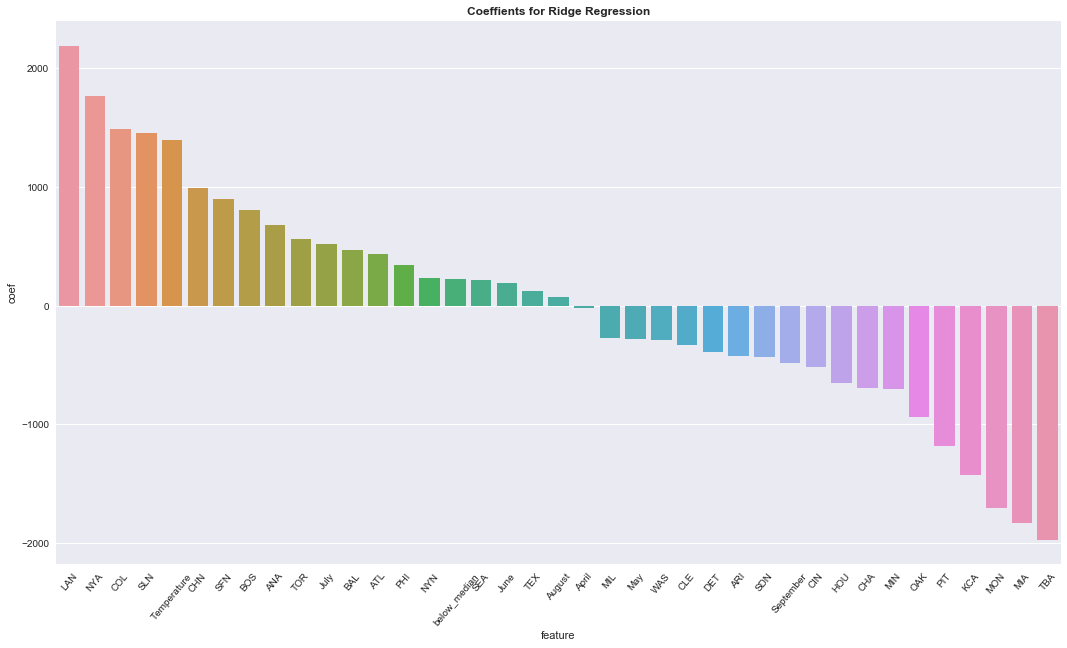

Highest positive impact features: 
                    coef
feature                 
LAN          2193.639472
NYA          1770.696408
COL          1485.748069
SLN          1453.688091
Temperature  1399.709129 

Highest negative impact features: 
                coef
feature             
PIT     -1187.335160
KCA     -1425.794053
MON     -1707.338321
MIA     -1837.081799
TBA     -1974.882123


In [50]:
## New ridge df to plot coefficients

df_r = pd.DataFrame()

df_r['feature'] = X_1t.columns
df_r['coef'] = ridge_s.coef_

df_r.sort_values(by='coef',ascending=False, inplace=True)
df_r.reset_index(inplace=True)
del df_r['index']

df_r.set_index('feature',inplace=True)

fig, ax = plt.subplots(figsize=(18, 10))

ax = sns.barplot(x=df_r.index, y=df_r['coef'])
plt.xticks(rotation=50)
plt.title('Coeffients for Ridge Regression', fontweight='bold')

plt.show()

print('Highest positive impact features: \n' + str(df_r[:5]), '\n')
print('Highest negative impact features: \n' + str(df_r[-5:]))

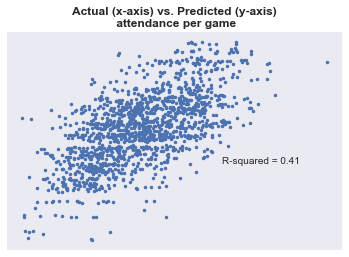

In [51]:
## Plot actual and predicted values for Ridge regression

plt.plot(y1s_test, ridge_pred_s, marker='.',linestyle='none')
plt.title('Actual (x-axis) vs. Predicted (y-axis)\n attendance per game', fontweight='bold')

plt.text(45000, 24000, 'R-squared = %.2f' %ridge_s.score(X1s_train, y1s_train), size=10)
plt.xticks([])
plt.yticks([])

plt.show()  

In [52]:
## Calculate errors

errors_r = abs(ridge_pred_s - y1s_test)

print('MAE:', round(np.mean(errors_r), 2), 'fans.')

# Calculate mean absolute percentage error (MAPE)

mape_r = 100 * (errors_r / y1s_test)

# Calculate and display accuracy

accuracy_r = 100 - np.mean(mape_r)

print('Accuracy:', round(accuracy_r, 2), '%.')

MAE: 5665.64 fans.
Accuracy: 77.74 %.


In [53]:
## Lasso regression with scaled data

lasso = Lasso()
lasso.fit(X1s_train, y1s_train)

preds_l = lasso.predict(X1s_test)

In [54]:
## Errors for Lasso regression

errors_l = abs(preds_l - y1s_test)

print('Lasso MAE:', round(np.mean(errors_l), 2), 'fans.')

# Calculate mean absolute percentage error (MAPE)

mape_l = 100 * (errors_l / y1s_test)

# Calculate and display accuracy

accuracy_l = 100 - np.mean(mape_l)

print('Accuracy:', round(accuracy_l, 2), '%.')

Lasso MAE: 5665.7 fans.
Accuracy: 77.74 %.


In [55]:
for f, coef in zip(X_1t.columns, lasso.coef_):
    print(f, round(coef,2))

Temperature 1401.5
below_median 225.69
April -0.0
May -259.21
June 206.74
July 536.07
August 86.38
September -469.57
ANA 720.33
ARI -387.92
ATL 468.79
BAL 506.38
BOS 841.26
CHA -657.91
CHN 1031.78
CIN -477.7
CLE -294.45
COL 1521.9
DET -355.73
HOU -610.42
KCA -1386.65
LAN 2231.82
MIA -1800.51
MIL -237.78
MIN -663.34
MON -1681.78
NYA 1808.91
NYN 266.69
OAK -904.9
PHI 378.3
PIT -1147.96
SDN -397.21
SEA 257.71
SFN 939.35
SLN 1491.52
TBA -1941.93
TEX 157.22
TOR 603.16
WAS -264.59


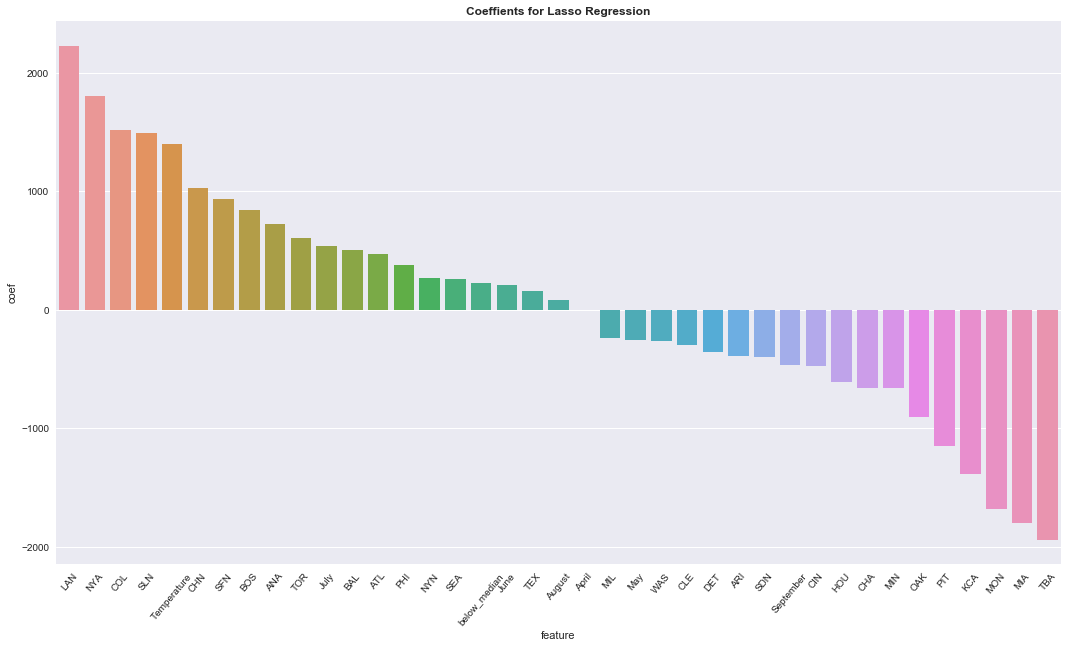

In [56]:
## Create a df with the lasso regression features and coefficients to plot

df_l = pd.DataFrame()

df_l['feature'] = X_1t.columns
df_l['coef'] = lasso.coef_

df_l.sort_values(by='coef',ascending=False, inplace=True)
df_l.reset_index(inplace=True)
del df_l['index']

df_l.set_index('feature',inplace=True)

fig, ax = plt.subplots(figsize=(18, 10))

ax = sns.barplot(x=df_l.index, y=df_l['coef'])
plt.xticks(rotation=50)
plt.title('Coeffients for Lasso Regression', fontweight='bold')

plt.show()

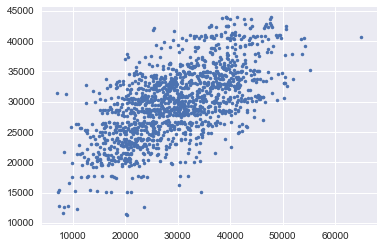

R-squared for Lasso: 0.41


In [57]:
## Plot lasso regression predictions against actual

plt.plot(y1s_test, preds_l, marker='.',linestyle='none')
plt.show()

print('R-squared for Lasso: %.2f' % lasso.score(X1s_train, y1s_train))    

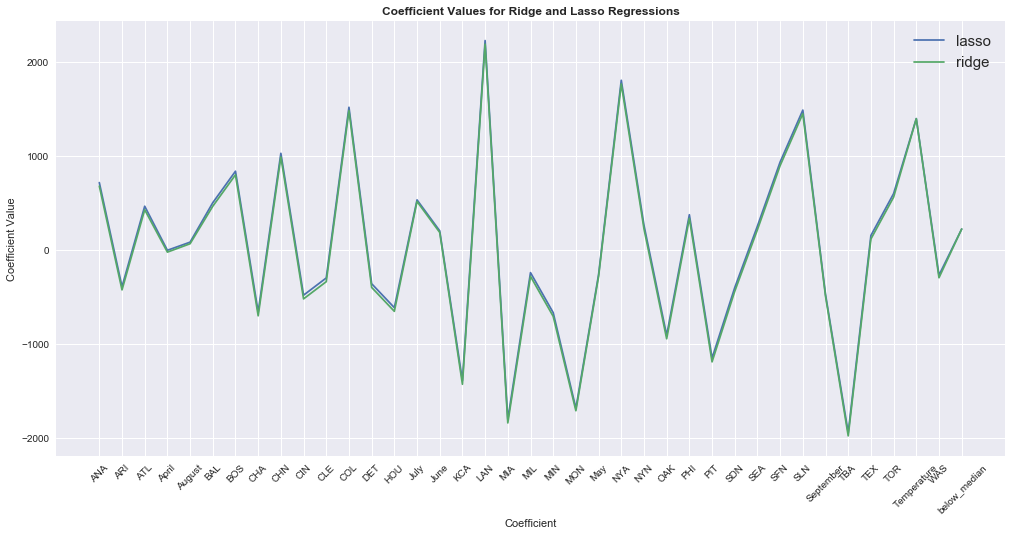

In [58]:
## Data frame with Ride and Lasso Coefficients to visually see the difference

ridge_lasso = pd.DataFrame(index=df_l.sort_index().index)
ridge_lasso['lasso'] = df_l.sort_index()['coef']
ridge_lasso['ridge'] = df_r.sort_index()['coef']

fig, ax = plt.subplots(figsize=(17, 8))

ax.plot(ridge_lasso.index, ridge_lasso['lasso'], label='lasso')
ax.plot(ridge_lasso.index, ridge_lasso['ridge'], label='ridge')
plt.xticks(rotation=45)
plt.ylabel('Coefficient Value')
plt.xlabel('Coefficient')
plt.legend(loc='best', prop={'size':15})
plt.title('Coefficient Values for Ridge and Lasso Regressions', fontweight='bold')

plt.show()

# Findings

The Ridge and Lasso regressions don't show overwhelming differences in the coefficient values, and both also show very similar MAE and accuracy scores.

Slope: 85.17
Intercept: 23807.94
Fit: 0.09


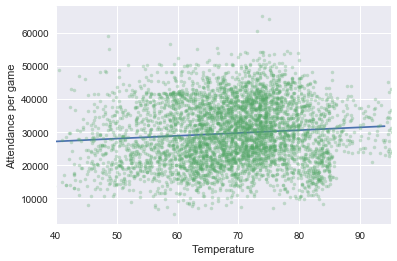

In [59]:
## Fit a straight linear regression model to Temperature and attendance per game

import dc_stat_think as dcst

slope, intercept = np.polyfit(X_1['Temperature'], y_1, 1)

print('Slope: %.2f' % slope)
print('Intercept: %.2f' % intercept)

print('Fit: %.2f' % dcst.pearson_r(X_1['Temperature'], y_1))

nums = np.arange(95)

plt.plot([slope*nums[i] + intercept for i in nums])
plt.plot(X_1['Temperature'], y_1, marker='.', linestyle='none', alpha=0.3)
plt.xlim([40, 95])
plt.xlabel('Temperature')
plt.ylabel('Attendance per game')

plt.show()

# Ridge Rergression with no Temperature indicators

We'll also examine the effect of removing Temperature and below-median values and only using month and team, understanding that Temperature will still be tangentially present via these variables (i.e. Temperature is partially dependent on month and team). We'll do this by comparing the MAE of a Ridge regression with all variables (already calculated) and a new model below with just the two named factors.

In [60]:
# Build and test a model with no temperature or below-median variables

to_exclude = ['Temperature', 'below_median']
no_temp = X_1t.drop(to_exclude, axis=1)

no_temp_scale = scale(no_temp)

X_nt_train, X_nt_test, y_nt_train, y_nt_test = train_test_split(no_temp, y_1, test_size=0.30, random_state = 15)

ridge_nt = Ridge()

ridge_nt.fit(X_nt_train, y_nt_train)

preds_nt = ridge_nt.predict(X_nt_test)

errors_nt = abs(preds_nt - y_nt_test)

print('No Temperature Ridge MAE:', round(np.mean(errors_nt), 2), 'fans.')

# Calculate mean absolute percentage error (MAPE)

mape_nt = 100 * (errors_nt / y_nt_test)

# Calculate and display accuracy

accuracy_nt = 100 - np.mean(mape_nt)

print('Accuracy:', round(accuracy_nt, 2), '%.')

No Temperature Ridge MAE: 5669.86 fans.
Accuracy: 77.68 %.


# Model 2: Random Forest

In [61]:
## Tune the data and instantiate the model

labels = np.array(y_1)
features = X1s.copy()

train_f, test_f, train_l, test_l = train_test_split(features, labels, test_size=0.7)

from sklearn.ensemble import RandomForestRegressor

# Instantiate model with 250 decision trees

rf = RandomForestRegressor(n_estimators = 250)

# Train the model on training data

rf.fit(train_f, train_l)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [62]:
## Use trained model to predict attendance

preds_rf = rf.predict(test_f)

In [63]:
errors = abs(preds_rf - test_l)

print('MAE:', round(np.mean(errors), 2), 'fans.')

# Calculate mean absolute percentage error (MAPE)

mape_rf = 100 * (errors / test_l)

# Calculate and display accuracy

accuracy_rf = 100 - np.mean(mape_rf)

print('Accuracy:', round(accuracy_rf, 2), '%.')

MAE: 6426.15 fans.
Accuracy: 75.22 %.


In [64]:
## Print features and importance of each variable

for feature, importance in zip(X_1t.columns, rf.feature_importances_):
    print(feature, round(importance,2))

Temperature 0.38
below_median 0.03
April 0.01
May 0.02
June 0.01
July 0.01
August 0.02
September 0.02
ANA 0.01
ARI 0.0
ATL 0.01
BAL 0.01
BOS 0.01
CHA 0.01
CHN 0.01
CIN 0.01
CLE 0.01
COL 0.03
DET 0.01
HOU 0.0
KCA 0.02
LAN 0.06
MIA 0.03
MIL 0.01
MIN 0.01
MON 0.03
NYA 0.06
NYN 0.01
OAK 0.01
PHI 0.01
PIT 0.01
SDN 0.0
SEA 0.01
SFN 0.01
SLN 0.04
TBA 0.04
TEX 0.0
TOR 0.01
WAS 0.0


Of the factors in the model, Temperature is most influential, but in looking at the MAE, it has the worst predictive power of the models created so far, and therefore the importance of Temperature should be seen in that light.

In [65]:
## Tune paremeters of Random Forest model

rf_1 = RandomForestRegressor(n_estimators = 200, criterion = 'mae', min_samples_leaf = 5)

rf_1.fit(train_f, train_l)

preds_rf1 = rf_1.predict(test_f)

mae_rf1 = mae(preds_rf1, test_l)

print('First tuned RF model MAE: %.2f' % mae_rf1)

First tuned RF model MAE: 5943.26


In [66]:
## Iterate over variables to look for most relevant

from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest

n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 50)]

# Number of features to consider at every split

max_features = ['auto', 'sqrt']

# Maximum number of levels in tree

max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [67]:
# Use the random grid to search for best hyperparameters

rf_2 = RandomForestRegressor()

rf_random = RandomizedSearchCV(estimator = rf_2, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(train_f, train_l)

rfr_pred = rf_random.predict(test_f)

errors_rfr = abs(rfr_pred - test_l)

print('MAE:', round(np.mean(errors_rfr), 2), 'fans.')

# Calculate mean absolute percentage error (MAPE)

mape_rfr = 100 * (errors_rfr / test_l)

# Calculate and display accuracy

accuracy_rfr = 100 - np.mean(mape_rfr)

print('Accuracy:', round(accuracy_rfr, 2), '%.')

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.4min finished


MAE: 5917.46 fans.
Accuracy: 76.72 %.


We see marginally better results with tuned parameters in the Random Forest model, but the MAE is still higher than the regression, so with the variables at hand, that looks to be the better predictor in this case.

# Statistical Significance

In order to test for statistical signifiance, we will specifically work with the cold weather cities in the spring months (April and May). We will look take the mean attendance per game as a group for when the temperature is above and below the median, then combine the datasets, take 10,000 random samples of the data, create a distribution, and calculate a p-value that compares the average of below-median games to the overall dataset.

In [68]:
## Make a copy of the correct data to work with and caculate each group's mean

df_stat = cold_spring_teams.copy()

df_stat = df_stat[['attendance_per_game', 'below_median']]

df_stat_belowm = df_stat[df_stat['below_median'] == 1]
df_stat_nbelowm = df_stat[df_stat['below_median'] == 0]

mean_belowm = df_stat_belowm['attendance_per_game'].mean()
mean_nbelowm = df_stat_nbelowm['attendance_per_game'].mean()

print('Mean for below median temperature games: %.2f fans' %mean_belowm)
print('Mean for above median temperature games: %.2f fans' %mean_nbelowm)

Mean for below median temperature games: 26691.77 fans
Mean for above median temperature games: 27621.35 fans


We have now taken the means of the two different datasets and do indeed see a difference of about 1,000 fans per game. Now, we will determine if this is just statistical noise or actual meaningful difference. The mean data are based on observations of ~500 for each one.

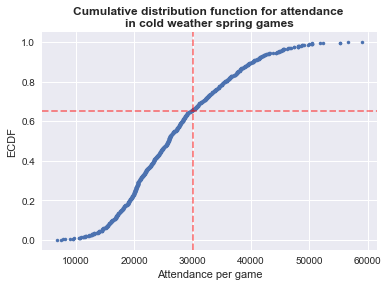

In [69]:
## Use the dc_stat_think module to take a random sample of the combined dataset with 10,000 with-replacement samples
## Start by plotting the ecdf to understand the cumulative distribution of the data. The way to interpret the chart is:
## "~65% of the observations for attendance per game are at or below 30,000 fans."

stat_x, stat_y = dcst.ecdf(df_stat['attendance_per_game'])

fig, ax = plt.subplots()

ax.plot(stat_x, stat_y, marker='.', linestyle='none')
ax.axvline(x=30000, c='red', alpha=0.5, linestyle='dashed')
ax.axhline(y=0.65, c='red', alpha=0.5, linestyle='dashed')
plt.xlabel('Attendance per game')
plt.ylabel('ECDF')
plt.title('Cumulative distribution function for attendance \nin cold weather spring games', fontweight='bold')

plt.show()

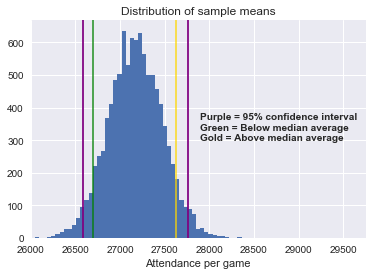

In [70]:
## Take the sample distributions and plot a histogram of the values

samples = dcst.draw_bs_reps(df_stat['attendance_per_game'], np.mean, 10000)

fig, ax = plt.subplots()

ax.hist(samples, bins=50)
ax.axvline(mean_belowm, color='green', alpha=0.75)
ax.axvline(mean_nbelowm, color='gold', alpha=0.75)
ax.axvline(np.percentile(samples, 2.5), color='purple')
ax.axvline(np.percentile(samples, 97.5), color='purple')
ax.text(27900, 300, 'Purple = 95% confidence interval \nGreen = Below median average \nGold = Above median average',
       fontweight='bold')

plt.xlim([26000, 29750])
plt.xlabel('Attendance per game')
plt.title('Distribution of sample means')

plt.show()

In [71]:
## Start by calculating the 95% confidence interval

percentile = np.percentile(samples, [2.5, 97.5])

print('The 95% confidence interval is: {0:.1f}, {1:.1f}'.format(*percentile))
print('The below median average is: %.1f' %mean_belowm)
print('The above median average is: %.1f' %mean_nbelowm)
print('The average for the combined data is: %.1f' %np.mean(df_stat['attendance_per_game']))

The 95% confidence interval is: 26582.8, 27764.9
The below median average is: 26691.8
The above median average is: 27621.3
The average for the combined data is: 27173.8


The 95% confidence interval contains both of our values, as we can see graphically and in the cell above. Though both are near the boundaries, we can't say with certainty that they are statistically different from the overall mean.

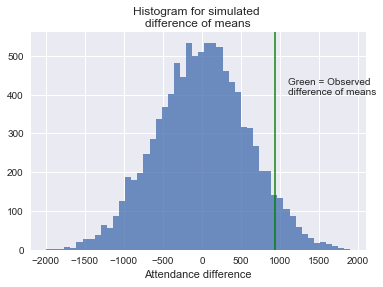

The observed difference of the two means is: 929.6 fans


In [72]:
## Test whether the difference of means between below- and above-median temperature is different than 0 for
## games in the spring for cold-weather teams.

perm_reps = dcst.draw_perm_reps(df_stat_nbelowm['attendance_per_game'], df_stat_belowm['attendance_per_game'], 
                                dcst.diff_of_means, size=10000)

diff_mean = dcst.diff_of_means(mean_nbelowm, mean_belowm)

fig, ax = plt.subplots()

ax.hist(perm_reps, bins=50, alpha=0.80)
ax.axvline(diff_mean, alpha=0.8, color='green')
ax.text(1100, 400, 'Green = Observed \ndifference of means')

plt.title('Histogram for simulated \ndifference of means')
plt.xlabel('Attendance difference')

plt.show()

print('The observed difference of the two means is: %.1f fans' %diff_mean)

In [73]:
## Calculate the p-value by summing the number of sample observations that are greater than our below-median average
## then divide by the total number of samples. If the number is > 0.05, we fail to reject the null hypothesis that there
## is no difference. If it is less than 0.05, there is evidence that below-median attendances are different than 
## above median attendances.

p_value = np.sum(perm_reps >= diff_mean) / len(perm_reps)

print('The observed p-value is: %.3f' %p_value)

The observed p-value is: 0.059


# Results

The observed p-value of 0.06 is just slightly outside of our 0.05 range, and therefore we fail to reject the null hypothesis that there is a statistically different average temperature when the temperature is above or below the mean in cold weather cities during the spring months.

# Conclusions

We cannot conclude with certainty that Temperature has a significant effect on attendance per game in Major League Baseball. This conclusion was reached through exploratory data analysis, modeling of Temperature with other contributing factors, and from a statitiscal perspective. While this doesn't tell the full story and there are deeper analyses that can be done with regard to Temperature and Attendance, I hope that it at least debunks the initial explanation from the MLB Commisioner that weather can explain a decrease in attendance. There are other fundamental challenges that the MLB could address - and are in their control - that will positively impact attendance per game. 

# Limitations of analysis and next steps

- Attendance per game is tickets sold and not necessarily "attendance", so the actual attendance could be lower than reported
- Scrape website for exact temperature per game
- Incorporate team record, playoff contention, previous year's success
- Consider visiting team and their record
- Isolate specific star players and see if there games (home or away) have better attendance